In [ ]:
import pulp
import numpy as np
import pandas as pd
from sklearn import  *
import random
import time
from sklearn.model_selection import train_test_split


# preprocess, make train and test


df = pd.read_excel('4clstrain1200.xlsx',header=None)

df1 = pd.read_excel('4clstest4000.xlsx',header=None)


x_test = df1.iloc[:,:2].values
y_test =  np.reshape(df1.iloc[:,2:].values,(1,len(df1.iloc[:,2:].values)))[0]

x_test_matrix = x_test
y_test_list = y_test

x = df.iloc[:,:2].values
y =  np.reshape(df.iloc[:,2:].values,(1,len(df.iloc[:,2:].values)))[0]


# data normalization
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

x_test_matrix = scaler.transform(x_test_matrix)              # wrongly_scaled = preprocessing.scale(x_test_matrix)
x_train_matrix = x
y_train_list = y

number_of_classes = 4  # -------------------------------------------------------------------------------------------------------------

#    outputs Gi's  in a 1D array     (Normalized)
def g_normalized_list (test_sample_list , train_data_designMX , standard_deviation) :
    g_unormalized = []
    g_normalized = []
    g_normalized_multiplied_by_real_y = []
    for sample in range (len(train_data_designMX)) :
        similarity = 1
        for feature in range (len(train_data_designMX[sample])) :
            similarity *= np.exp(- ((train_data_designMX[sample][feature] - test_sample_list [feature]) **2 ) / standard_deviation)
        g_unormalized.append(similarity)
    for i in range (len(g_unormalized)) :
        g_normalized.append(g_unormalized[i]/sum(g_unormalized))

    # for i in range (len(g_normalized)) :
    #     g_normalized_multiplied_by_real_y.append( g_normalized [i] * y_of_train_list [i] )

    return g_normalized



In [ ]:
v_multi_class = []

#    REGULARIZATION terms --------------------------------------------------------
regularization_term = 1/2
std = 0.1

for kk in range(number_of_classes) :
    y_temp = []
    for i in range (len(y_train_list)) :
        if y_train_list [i] == (kk+1) :
            y_temp .append( 1)
        else : y_temp  .append(-1)

    # ------------------------------------------------------------------------------
    """ Linear Programing Optimization for multiple classification """
    # ------------------------------------------------------------------------------

    # Linear Programing model
    model = pulp.LpProblem('Fuzzy Neural Network Optimization', pulp.LpMinimize)

    # variables
    variables_v_list = []
    variables_eps_list = []
    variables_t_for_v_list = []
    # variables_p_for_eps_list = []

    #                            Variable V
    for i in range(len(x_train_matrix) + 1):
        variable_v = pulp.LpVariable(str('v' + str(i)))
        variable_t_for_v = pulp.LpVariable(str('t' + str(i)))
        variables_v_list.append(variable_v)
        variables_t_for_v_list.append(variable_t_for_v)

    #                            Varibale Epsilon
    for i in range(len(x_train_matrix)):
        variable_epsilon = pulp.LpVariable(str('eps' + str(i + 1)))
        variable_p_for_eps = pulp.LpVariable(str('p' + str(i + 1)))
        variables_eps_list.append(variable_epsilon)
        # variables_p_for_eps_list.append(variable_p_for_eps)

    # objective function preproccess
    soosk = ''
    for i in range(len(variables_t_for_v_list)):
        soosk += variables_t_for_v_list[i]
    soosk1 = ''
    for i in range(len(variables_eps_list)):
        soosk1 += -variables_eps_list[i]

    # The OBJECTIVE FUNCTION
    model += soosk + soosk1, 'Last Layer weights'

    # CONSTRAINS-----------------------------------

    #                   INEQUALITIES
    for i in range(len(variables_t_for_v_list)):
        model += (variables_t_for_v_list[i]) >= (variables_v_list[i] * regularization_term)
        model += (variables_t_for_v_list[i]) >= - (variables_v_list[i] * regularization_term)

        model += variables_v_list[i] >= -9999

    for j in range(len(variables_eps_list)):
        summ = variables_v_list[0]
        list_temp = g_normalized_list(x_train_matrix[j], x_train_matrix, std)
        for i in range(1, len(variables_eps_list) + 1):
            summ += variables_v_list[i] * list_temp[i - 1]

        model += 1 + variables_eps_list[j] <= summ * y_temp[j]

        model += variables_eps_list[j] <= 10000

    start_time = time.time()

    # Solving the problem
    results = model.solve()


    end_time = time.time()

    # print solving status
    print('Status :', pulp.LpStatus[model.status],'\n\n')


    # Extracting V values  to a final list called V_list
    v_list = []
    temp_v_list = []
    temp_v_list1 = []
    for i in model.variables():
        # if 'v' in i.name :                                     # print variable values
        # print(i.name,'=',i.varValue)                       # print variable values

        if 'v' in i.name:
            temp_v_list.append((i.name, i.varValue))
    for i in range(len(temp_v_list)):
        i, j = temp_v_list[i]
        i = i.replace('v', '')
        temp_v_list1.append((int(i), j))
    sorted_list = sorted(temp_v_list1, key=lambda tup: (tup[0]))
    for i in range(len(sorted_list)):
        i, j = sorted_list[i]
        v_list.append(j)

    v_multi_class .append(v_list)

    print('\nTime Elapsed at Optimization Solver i =', end_time - start_time, 'seconds')



Status : Optimal 





Time Elapsed at Optimization Solver i = 23.648480653762817 seconds


Status : Optimal 





Time Elapsed at Optimization Solver i = 19.733476400375366 seconds


Status : Optimal 





Time Elapsed at Optimization Solver i = 26.152649641036987 seconds


Status : Optimal 





Time Elapsed at Optimization Solver i = 25.18089771270752 seconds


In [ ]:
count_gs = len(x_train_matrix)*[0]
for i in range (len(v_multi_class)):
    for j in range (1,len(v_multi_class[0])-1) :
        if not v_multi_class [i][j] == 0 :
            count_gs [j] += 1
            
num_zero_g = 0
for i in range (len(count_gs)):
    if count_gs [i] == 0 :
        num_zero_g += 1

# Report Number f rules --------------
# county = 0
# for i in range (len(v_multi_class)):
#     for j in range (len(v_multi_class[0])):
#         if v_multi_class[i][j] == 0 :
#          county += 1

print('Total Number of Possible Rules =', len(x_train_matrix))
print('\nTotal Number Of Deactivated Rules  (Vi = 0) =',num_zero_g )
print('\nTotal Number Of Active Rules =',len(x_train_matrix) - num_zero_g )

Total Number of Possible Rules = 1200

Total Number Of Deactivated Rules  (Vi = 0) = 1035

Total Number Of Active Rules = 165


In [ ]:


# -----  Prediction of Binary Classification (-1,1) Based On Training Set And Gived Vi's   ------
def predict_Binary_Classification  (test_sample_list , train_data_designMX , v_values ,  standard_deviation) :
    g_unormalized = []
    g_normalized = []
    for sample in range (len(train_data_designMX)) :
        similarity = 1
        for feature in range (len(train_data_designMX[sample])) :
            similarity *= np.exp(- ((train_data_designMX[sample][feature] - test_sample_list [feature]) **2 ) / standard_deviation)
        g_unormalized.append(similarity)
    for i in range (len(g_unormalized)) :
        g_normalized.append(g_unormalized[i]/sum(g_unormalized))
    # print('g=',g_normalized)
    yyyyy = []
    for i in range (len(v_values)):
        maaa_v = v_values[i].copy()
        v0 = maaa_v.pop(0)
        predict = 0
        for i in range (len(g_normalized)) :
            predict += (g_normalized[i] * maaa_v[i])
        predict += v0
        yyyyy.append(predict)
    # print(yyyyy)

    # for i in range (len(g_normalized)) :
    #     g_normalized_multiplied_by_real_y.append( g_normalized [i] * y_of_train_list [i] )
    out_put = yyyyy.index(max(yyyyy))+1

    return out_put






miss_samples = []

accuracy_train = 0
for i in range (len(x_train_matrix)) :
    # print(predict_Binary_Classification(x_train_matrix[i],x_train_matrix , v_list , std ) )
    if predict_Binary_Classification(x_train_matrix[i],x_train_matrix , v_multi_class , std ) == y_train_list[i] :
        accuracy_train += 1
print('\n\naccuracy train = ',(accuracy_train/len(x_train_matrix))*100, ' %')

print('----------------------')

accuracy_test = 0
for i in range (len(x_test_matrix)) :
    if predict_Binary_Classification(x_test_matrix[i],x_train_matrix , v_multi_class , std ) == y_test_list[i] :
        accuracy_test += 1
    else :  miss_samples.append(x_test_matrix[i])
print('accuracy test = ',(accuracy_test/len(x_test_matrix))*100,' %')







accuracy train =  97.33333333333334  %
----------------------


accuracy test =  97.675  %


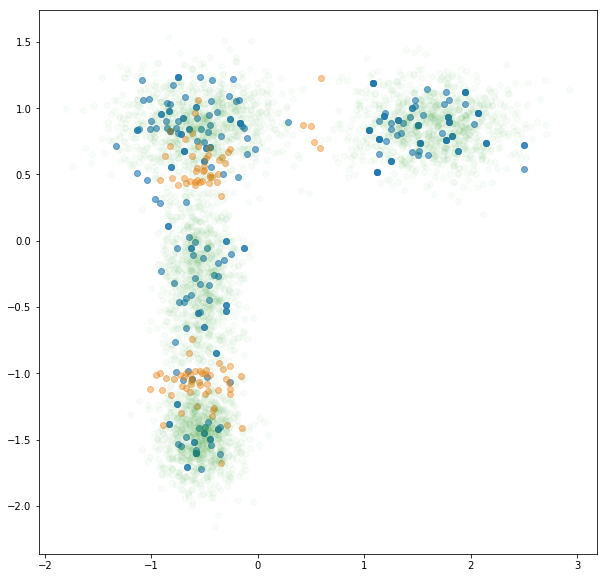

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10 , 10

centers = []
for i in range (len(v_multi_class)):
   for j in range (len(v_multi_class[0])-1):
       if not v_multi_class [i][j] == 0 :
           centers.append(x_train_matrix[j])
        
        
    




x_centers = []
y_centers = []
for i in range (len(centers)) :
    x_centers.append(centers[i][0])
    y_centers.append(centers[i][1])
plt.scatter(x_centers,y_centers,alpha=0.6)


x_miss = []
y_miss = []
for i in range (len(miss_samples)):
    x_miss.append(miss_samples[i][0])
    y_miss.append(miss_samples[i][1])
    
plt.scatter(x_miss , y_miss ,alpha= 0.4)


x_all_test = []
y_all_test = []
for i in range (len(x_test_matrix)):
    x_all_test.append(x_test_matrix[i][0])
    y_all_test.append(x_test_matrix[i][1])
    
plt.scatter(x_all_test,y_all_test,alpha=0.03)

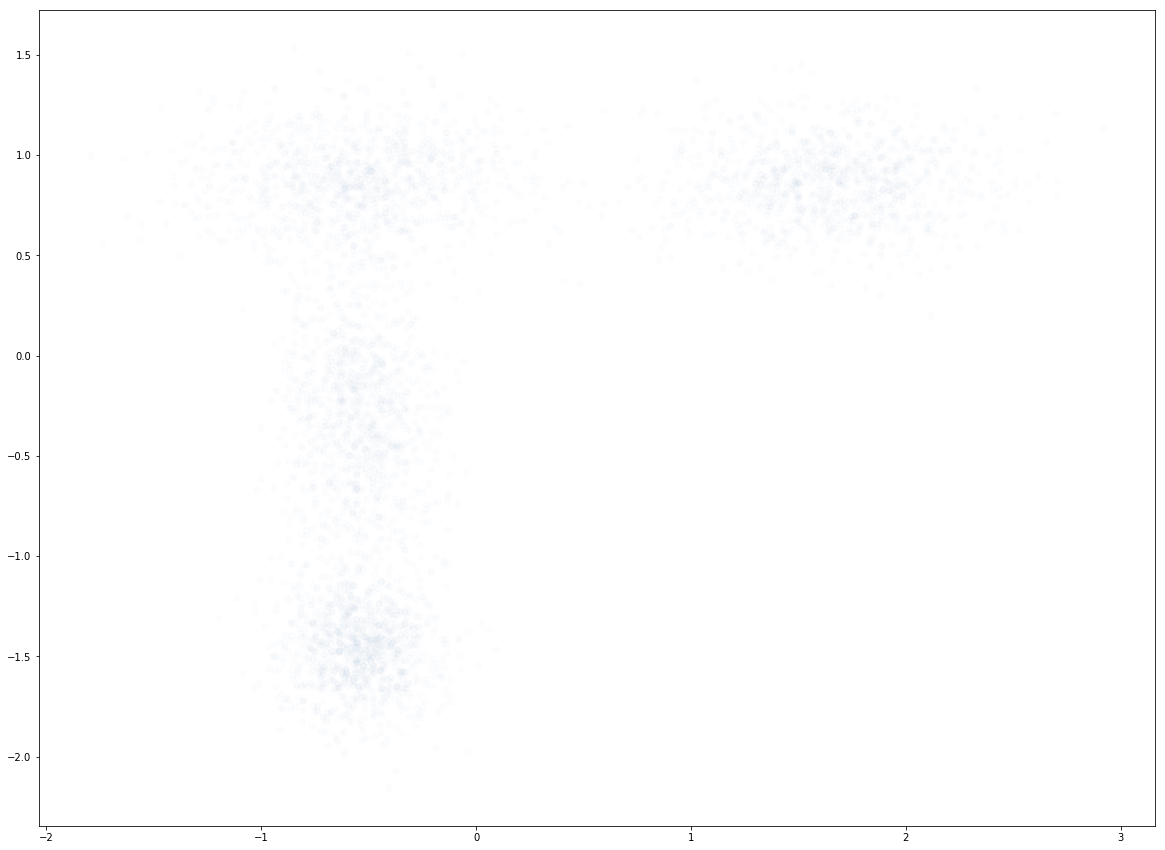

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20 , 15

plt.scatter(x_all_test,y_all_test,alpha=0.01)